https://www.tensorflow.org/tutorials/text/word_embeddings

https://stackabuse.com/python-for-nlp-word-embeddings-for-deep-learning-in-keras/

https://medium.com/analytics-vidhya/implementing-word2vec-in-tensorflow-44f93cf2665f

In [1]:
import tensorflow.compat.v1 as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import os
# import pandas as pd 
from nltk.tokenize import sent_tokenize, word_tokenize
from scipy import spatial
import nltk
import requests
nltk.download('punkt')
import gensim
import re
import sys
sys.setrecursionlimit(10**6)
import random
import numpy as np
from collections import OrderedDict
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import json
tf.compat.v1.disable_eager_execution()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Prepare Data

### Prepare query words for querying the server

In [2]:
foods = pd.read_csv("foods.csv", delimiter=",", skipinitialspace=True)

# Get unique words
unique_words = foods["food_name"].unique()
query_words = list(unique_words) # list of words we will query
# query_words = query_words[::2]
query_words = random.sample(query_words, 300)

def make_query_string(blim, tlim):
    string = ""
    a = 0
    for word in query_words[blim:tlim]:
        a+=1
        word.replace(",", "")
        if a == len(query_words[blim:tlim]):
            string = string+word
        else:
            string = string+word+","
    return string

def make_all_query_strings():
    strings = []
    blim = 0
    tlim = 100
    a = False
    while tlim <= len(query_words):
        string = make_query_string(blim, tlim)
        strings.append(string)
        if a is True:
            return strings
        blim += 100
        tlim += 100
        if tlim >= len(query_words) and a == False:
            tlim = len(query_words)
            a = True
        print(a)
        

server_name = "http://localhost:5000"

def get_corpus():
    strings = make_all_query_strings()
    responses = []
    a = 0
    for string in strings:
        r = requests.get(server_name+"/recipes?queries={}&number=10".format(string))
        if r.status_code != 200:
            print("Error: {} - {}".format(r.status_code, r.text))
        else:
            print("Success")
        responses.append(r.json())
        print(a)
        a+=1
    return responses

### Get and Save Corpus

In [6]:
corpus = get_corpus()

False
True


ConnectionError: HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /recipe?query=Coffee%20Mocha,mashed%20sweet%20potato,Pasta%20Salads,earl%20grey%20tea,chicken%20salad%20sandwich,Peanut%20Bar,%20Fresh%20Roasted,balsamic%20dressing,Maple%20Almond%20Butter,Maple%20Pecan%20Granola%20Cereal,Spaghetti,Mushroom%20&%20Truffle%20Italian%20Flatbread%20Pizza,country%20crock,grape,Roasted%20&%20Salted%20Shelled%20Pistachios,Gourmet%20Popcorn,Hook%20&%20Ladder%20-%20Medium,Tortilla%20Chips,%20Blue%20Chips,Pumpkin%20spice%20cake,Shells%20&%20White%20Cheddar,Dip,%20French%20Onion,Challah,nectarines,low%20fat%20milk,toast%20with%20jam,pulled%20pork,vegetable%20medley,fresh%20squeezed%20juice,Greek%20Dressing,dutch%20baby,jelly%20belly,Cheese%20Stick,%20Wisconsin%20Sharp%20Cheddar%20Natural,Napa%20Cabbage%20Kimchi,%20Classic,wild%20rice,gingerbread%20cookies,chick%20fil%20a%20grilled%20nuggets%208%20count,frozen%20mixed%20vegetables,canned%20peaches,Strawberry%20Non-fat%20Yogurt,diet%20mountain%20dew,romaine,corn%20canned,Tropical%20Punch,Shells%20&%20Cheese,%20Jumbo%20Shells,%20Original,pink%20lady%20apple,100%25%20Cranberry%20Juice,corn%20salsa,whole%20wheat%20roll,Weekday%20breakfast,cheese%20quesadia,cherry%20tomatoes,roasted%20pumpkin%20seeds,steamed%20shrimp%20dumpling,Yogurt%20topping,mixed%20green%20salad,oatmeal%20cookie,pork%20roast,carnitas%20taco,mozzarella,Arnold%20Palmer,Tomato%20Avocado%20Salad,Protein%20Smoothie,honey%20roasted%20turkey,ziti%20pasta,Moroccan%20Lamb%20Stew%20with%20Couscous,bigmac,taco%20meat,macaroni%20cheese,Lemonade,%20Small,low%20fat%20cream%20cheese,fish%20tacos,Diced%20Potatoes%20with%20Onions,mushroom%20spinach%20pizza,Egg%20Scramble,steel%20cut%20oatmeal,grated%20parmesan,Honeycrisp%20Apple%20Cider%20Blend,Sprouted%20Whole%20Grain%20Bread,Pistachio,Peanut%20Butter%20Tree,%20Milk%20Chocolate,Sliced%20Apples,cilantro%20sauce,Organic%20Bratwurst%20Chicken%20Sausage,swedish%20meatballs,grits%20dry,chili%20sauce,white%20fish,Nutty%20Bars,Fat%20Free%20Balsamic%20Vinaigrette%20Dressing,jalapeno,Stuffing,%20Cornbread,apple%20cider%20vinegar,Peach%20Blueberry%20Pie,iced%20tea,Seasoned%20Collard%20Greens,corn%20tortillas,This%20Cranberry%20Walks%20into%20a%20Bar%20Cereal%20Bars,Whole%20Grains%20Bread,almond,chicken%20boneless%20skinless,blackberry%20jelly&number=10 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fbc62c3ec18>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [17]:
# Save to JSON so that we don't have to query again
my_json = json.dumps(corpus)
with open("corpus.json", "w") as f:
    json.dump(my_json, f)

### Call load corpus.json if already ran get_corpus(), make vocab

In [2]:
with open("corpus0-50_3.json", "r") as f:
    corpus = json.load(f)
corpus=json.loads(corpus)
print(type(corpus))

<class 'list'>


In [3]:
words = []
for response in corpus: # for query word response
    for query in response:
        if query["corpus"] == "":
            continue
        else:
            paragraph = query["corpus"].lower()
            sentences = re.split(r"[.!?]", paragraph)
            for sentence in sentences: 
                sentence = sentence.replace(",", "")
                nltk_tokens = word_tokenize(sentence)
                nltk_tokens = [word for word in nltk_tokens if len(word)>1 and word.isalpha()]
                words.extend(nltk_tokens)

In [4]:
vocab = set(words)
char_to_int = dict((c,i) for i,c in enumerate(vocab))
int_to_char = dict((i,c) for i,c in enumerate(vocab))
print(len(vocab))

1788


### Context

In [5]:
X = []
Y = []
temp_dict = []
window_size = 5
for i in range(len(words)):
    a = i-window_size
    b= i+window_size
    curr_word = words[i]
    for z in range(a,i):
        if z >=0:
            temp_dict.append((curr_word,words[z]))
    for z in range(i+1,b):
        if z<len(vocab):
            temp_dict.append((curr_word,words[z]))
for pair in temp_dict:
    tempx = np.zeros(len(vocab))
    tempy = np.zeros(len(vocab))
    tempx[char_to_int[pair[0]]] = 1
    tempy[char_to_int[pair[1]]] = 1
    X.append(tempx)
    Y.append(tempy)

### Embeddings and Weight Updating

In [6]:
embedding_size = 100
batch_size = 64
epochs = 100 
n_batches = int(len(X)/batch_size)
learning_rate= 0.001
x = tf.placeholder(tf.float32,shape = (None,len(vocab)))
y = tf.placeholder(tf.float32,shape = (None,len(vocab)))
w1 = tf.Variable(tf.random_normal([len(vocab),embedding_size]),dtype = tf.float32)
b1 = tf.Variable(tf.random_normal([embedding_size]),dtype = tf.float32)
w2 = tf.Variable(tf.random_normal([embedding_size,len(vocab)]),dtype = tf.float32)
b2 = tf.Variable(tf.random_normal([len(vocab)]),dtype = tf.float32)
hidden_y = tf.matmul(x,w1) + b1
y_pred = tf.matmul(hidden_y,w2) + b2
#print(b.dtype)
#_y = tf.matmul(x,w)
cost = tf.reduce_mean(tf.losses.mean_squared_error(y_pred,y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
print(y.shape)
print(y_pred.shape)
init = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()
saver = tf.train.Saver()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.33)
sess = tf.Session(config = tf.ConfigProto(gpu_options = gpu_options))
sess.run(init)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(None, 1788)
(None, 1788)


### Train

In [7]:
for epoch in range(100):
    avg_cost = 0
    for i in range(n_batches-1):
        batch_x = X[i*batch_size:(i+1)*batch_size]
        batch_y = Y[i*batch_size:(i+1)*batch_size]
        #print(batch_x.shape)
        _,c = sess.run([optimizer,cost],feed_dict = {x:batch_x,y:batch_y})
        #print(test.shape)
        
        avg_cost += c/n_batches
    print('Epoch',epoch,' - ',avg_cost)

Epoch 0  -  59.69668792391576
Epoch 1  -  15.784878812139024
Epoch 2  -  5.237910954488652
Epoch 3  -  1.7434379423421558
Epoch 4  -  0.5692327249179262
Epoch 5  -  0.18101631107151228
Epoch 6  -  0.056569527404717844
Epoch 7  -  0.01797273721987575
Epoch 8  -  0.006298177413428053
Epoch 9  -  0.002730854804702743
Epoch 10  -  0.0015738122582819977
Epoch 11  -  0.0011581893826135105
Epoch 12  -  0.0009819669629910367
Epoch 13  -  0.000900615030861455
Epoch 14  -  0.0008620248590694565
Epoch 15  -  0.0008443063088980986
Epoch 16  -  0.0008328873436853654
Epoch 17  -  0.0008556450212068822
Epoch 18  -  0.0008373335527721798
Epoch 19  -  0.0008387219212535353
Epoch 20  -  0.0008378300754225261
Epoch 21  -  0.0008350993730817696
Epoch 22  -  0.0008238849424136175
Epoch 23  -  0.0008266614032441144
Epoch 24  -  0.0008069100604631577
Epoch 25  -  0.0008313968465059855
Epoch 26  -  0.0008051352489187766
Epoch 27  -  0.0008120740096456826
Epoch 28  -  0.0007955922042364607
Epoch 29  -  0.00081

### Get all the words embedded

In [8]:
embeddings = dict()
for i in vocab:
    temp_a = np.zeros([1,len(vocab)])
    temp_a[0][char_to_int[i]] = 1
    temp_emb = sess.run([y_pred],feed_dict = {x:temp_a})
    temp_emb = np.array(temp_emb)
    #print(temp_emb.shape)
    embeddings[i] = temp_emb.reshape([len(vocab)])
    #print(embeddings[i].shape)

### Find the closest words

In [26]:
def closest(word,n):
    distances = dict()
    for w in embeddings.keys():
        distances[w] = spatial.distance.cosine(embeddings[w],embeddings[word])
    d_sorted = OrderedDict(sorted(distances.items(),key = lambda x:x[1] ,reverse = False))
    s_words = [key for key in d_sorted.keys()]
    print(s_words[:n])
    return s_words[:n]

In [81]:
closest_words = closest("mushroom",50)
closest_words2 = closest("cake", 50)
cw3 = closest("sushi", 50)
closest_words.extend(closest_words2)
closest_words.extend(cw3)
setlist = list(set(closest_words))
print(setlist)

['mushroom', 'edamame', 'attachment', 'asian', 'turn', 'roasting', 'tastes', 'hindsight', 'lift', 'wheat', 'wont', 'discarding', 'flowed', 'wo', 'full', 'unless', 'flatten', 'possible', 'stems', 'hard', 'hedi', 'proportioned', 'popsicle', 'spring', 'lower', 'fresh', 'lit', 'crumbles', 'nullpear', 'meatball', 'ranchera', 'skewer', 'cling', 'freeze', 'saturated', 'pudding', 'toasted', 'sauteed', 'lifted', 'missed', 'scooping', 'pappardelle', 'save', 'row', 'processing', 'eye', 'equally', 'buttery', 'dijon', 'especially']
['cake', 'searching', 'lemon', 'as', 'cover', 'could', 'remaining', 'batter', 'sauce', 'banana', 'vegetables', 'over', 'butter', 'coffee', 'syrup', 'eggs', 'flour', 'medium', 'low', 'sugar', 'follow', 'pan', 'cream', 'small', 'bowl', 'then', 'they', 'meanwhile', 'fold', 'pepper', 'cocoa', 'heat', 'salt', 'are', 'together', 'water', 'wine', 'sweet', 'time', 'parmesan', 'dessert', 'food', 'juice', 'evenly', 'refrigerator', 'white', 'at', 'powder', 'baking', 'yogurt']
['sus

In [53]:
print(spatial.distance.cosine(embeddings["chicken"], embeddings["beef"]))
print(spatial.distance.cosine(embeddings["chicken"], embeddings["pasta"]))
print(spatial.distance.cosine(embeddings["chicken"], embeddings["cheese"]))
print(spatial.distance.cosine(embeddings["chicken"], embeddings["salad"]))

print(spatial.distance.cosine(embeddings["chicken"], embeddings["oats"]))
print(spatial.distance.cosine(embeddings["milk"], embeddings["soup"]))
print(spatial.distance.cosine(embeddings["onion"], embeddings["cookie"]))
print(spatial.distance.cosine(embeddings["jalapenos"], embeddings["oats"]))
print(spatial.distance.cosine(embeddings["pancake"], embeddings["swordfish"]))

0.3085654377937317
0.4348180890083313
0.2516229748725891
0.1254919171333313
1.0296487752348185
0.8303672224283218
0.7533785253763199
0.9365348741412163
1.1294266134500504


### Find the closest clusters for graphing

### Visualization

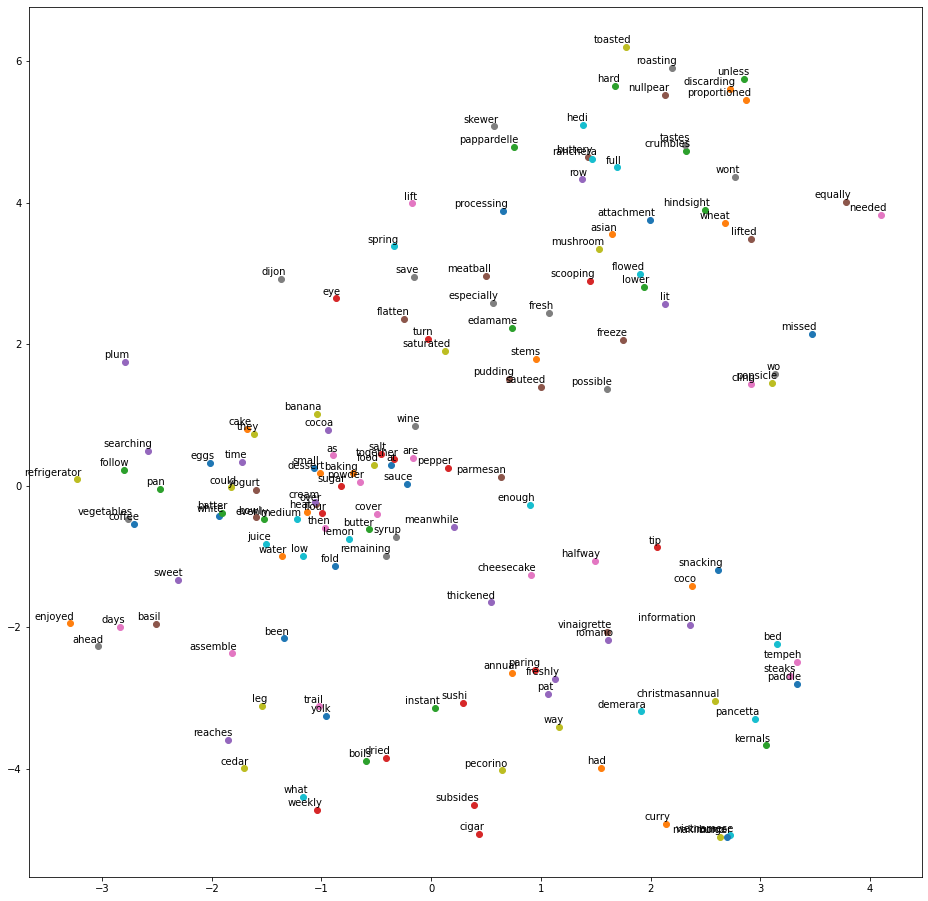

In [82]:
labels = []
tokens = []
for w in setlist:
    labels.append(w)
    tokens.append(embeddings[w])
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
plt.show()

In [109]:
# BUFFER_SIZE = 500
# BATCH_SIZE = 32
# TAKE_SIZE = round(.2*len(paragraphs(dataset_size)))

# print(TAKE_SIZE)

2586


### Load text into datasets

In [110]:
# def labeler(example, index):
#     return example, tf.cast(index, tf.int64)  

# labeled_data_sets = []

# for i, recipe in enumerate(paragraphs):  
#     lines_dataset = tf.data.Dataset.from_tensor_slices(recipe)
#     labeled_dataset = lines_dataset.map(lambda a: labeler(a, i))
#     labeled_data_sets.append(labeled_dataset)

# all_labeled_data = labeled_data_sets[0]
# for labeled_dataset in labeled_data_sets[1:]:
#     all_labeled_data = all_labeled_data.concatenate(labeled_dataset)

# all_labeled_data = all_labeled_data.shuffle(
#     BUFFER_SIZE, reshuffle_each_iteration=False)

### Tokenize

In [148]:
# tokenizer = tfds.features.text.Tokenizer()

# vocabulary_set = set()
# for text_tensor, _ in all_labeled_data:
#     some_tokens = tokenizer.tokenize(text_tensor.numpy())
#     vocabulary_set.update(some_tokens)

# vocab_size = len(vocabulary_set)
# print(vocab_size)

5184


### Encode

In [112]:
# encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

# example_text = next(iter(all_labeled_data))[0].numpy()
# print(example_text)

# encoded_example = encoder.encode(example_text)
# print(encoded_example)


# def encode(text_tensor, label):
#     encoded_text = encoder.encode(text_tensor.numpy())
#     return encoded_text, label

# def encode_map_fn(text, label):
#     # py_func doesn't set the shape of the returned tensors.
#     encoded_text, label = tf.py_function(encode, 
#                                        inp=[text, label], 
#                                        Tout=(tf.int64, tf.int64))

#     # `tf.data.Datasets` work best if all components have a shape set
#     #  so set the shapes manually: 
#     encoded_text.set_shape([None])
#     label.set_shape([])

#     return encoded_text, label


# all_encoded_data = all_labeled_data.map(encode_map_fn)
# print(all_encoded_data)

b'cook 1 to 2 minutes, or until tofu is heated through, shaking pan or gently stirring to toss tofu in spice mixture'
[4896, 4888, 2983, 2542, 2159, 5122, 3991, 4747, 1399, 3224, 1527, 4120, 1673, 5122, 4545, 1888, 2983, 2783, 4747, 4574, 4384, 2379]
<MapDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>


### Test/train split

In [155]:
# train_data = all_encoded_data.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)
# train_data = train_data.padded_batch(BATCH_SIZE, padded_shapes=([None],[]))

# test_data = all_encoded_data.take(TAKE_SIZE)
# test_data = test_data.padded_batch(BATCH_SIZE, padded_shapes=([None],[]))

# vocab_size += 1 # zero padding increases vocab size by 1

## Model

In [162]:
# embedding_dim=100

# model = tf.keras.Sequential()
# model.add(layers.Embedding(vocab_size, embedding_dim))
# model.add(layers.GlobalAveragePooling1D())
# # One or more dense layers.
# # Edit the list in the `for` line to experiment with layer sizes.
# # model.add(layers.Dense(100, activation='relu'))

# # Output layer. The first argument is the number of labels.
# model.add(tf.keras.layers.Dense(165))

# model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, None, 100)         518500    
_________________________________________________________________
global_average_pooling1d_26  (None, 100)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 165)               16665     
Total params: 535,165
Trainable params: 535,165
Non-trainable params: 0
_________________________________________________________________


## Compile

In [163]:
# adam = tf.keras.optimizers.Adam(learning_rate = .001)
# model.compile(optimizer=adam,
#               loss=["mse"],
#               metrics=['accuracy'])

## Fit

In [164]:
# history = model.fit(
#     train_data,
#     epochs=100,
#     validation_data=test_data)

Train for 324 steps, validate for 81 steps
Epoch 1/100
324/324 [==============================] - 23s 71ms/step - loss: 9496.0045 - accuracy: 0.0000e+00 - val_loss: 204.2301 - val_accuracy: 0.0000e+00
Epoch 2/100
324/324 [==============================] - 23s 70ms/step - loss: 4158.3618 - accuracy: 0.0000e+00 - val_loss: 3088.3258 - val_accuracy: 0.0000e+00
Epoch 3/100
324/324 [==============================] - 23s 72ms/step - loss: 1549.8960 - accuracy: 0.0000e+00 - val_loss: 7413.8607 - val_accuracy: 0.0000e+00
Epoch 4/100
324/324 [==============================] - 21s 64ms/step - loss: 1433.1348 - accuracy: 0.0000e+00 - val_loss: 9191.1990 - val_accuracy: 0.0000e+00
Epoch 5/100
324/324 [==============================] - 21s 64ms/step - loss: 1527.4226 - accuracy: 0.0000e+00 - val_loss: 9566.9295 - val_accuracy: 0.0000e+00
Epoch 6/100
324/324 [==============================] - 21s 64ms/step - loss: 1516.5570 - accuracy: 0.0000e+00 - val_loss: 9651.1504 - val_accuracy: 0.0000e+00
Epoc

In [ ]:
# eval_loss, eval_acc = model.evaluate(test_data)

# print('\nEval loss: {:.3f}, Eval accuracy: {:.3f}'.format(eval_loss, eval_acc))

In [ ]:
# e = model.layers[0]
# weights = e.get_weights()[0]
# print(weights.shape) # shape: (vocab_size, embedding_dim)